In [136]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, transpile
from qiskit.quantum_info import random_clifford, entropy
import random

In [152]:
n_qubits = 4 # make sure this is even or everything breaks
T = 4
qr = QuantumRegister(n_qubits, 'q')
cr = ClassicalRegister(n_qubits, 'c')
circ = QuantumCircuit(qr, cr)
p = 0.05

for t in range(T):
    for i in range(n_qubits // 2):
        circ.append(random_clifford(2), [qr[2*i], qr[2*i+1]])
    for i in range(n_qubits):
        if random.random() < p:
            circ.measure(qr[i], cr[i])

    for j in range((n_qubits - 1) // 2):
        circ.append(random_clifford(2), [qr[2*j+1], qr[2*j+2]])
    circ.append(random_clifford(2), [qr[-1], qr[0]])
    
    for j in range(n_qubits):
        if random.random() < p:
            circ.measure(qr[j], cr[j])

circ.save_state(pershot = True)

# circ.measure_all(add_bits = False)

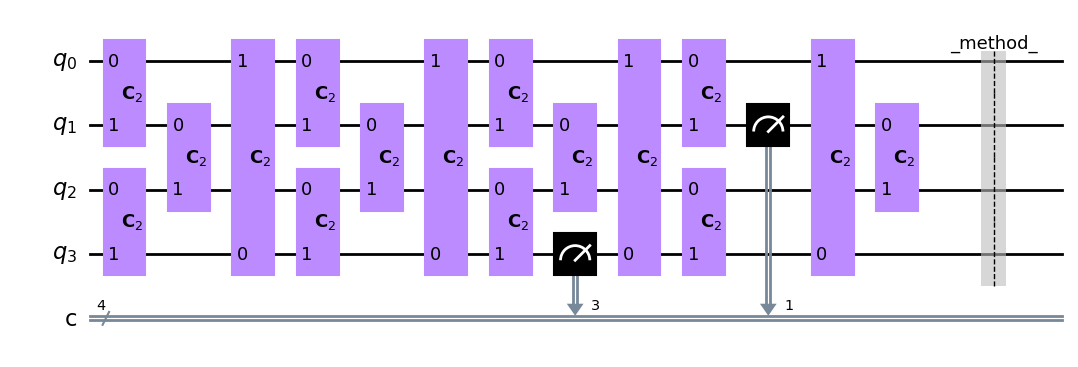

In [153]:
style = {
    'displaytext': {
        'clifford': r'\mathbf{C}_2'
    }
}

circ.draw('mpl', style = style)

In [139]:
simulator = Aer.get_backend('aer_simulator_stabilizer')
circ = transpile(circ, simulator)

In [140]:
# circ.draw('mpl')

In [141]:
result = simulator.run(circ, shots = 10000).result()
stabs = result.data()['stabilizer']

In [142]:
test_stab = stabs[0]

In [155]:
cliff = test_stab.clifford

In [179]:
import galois
import numpy as np

In [170]:
GF = galois.GF(2)

In [176]:
stab_2 = GF(cliff.stab.astype(int))

In [177]:
stab_2

GF([[0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 0, 1, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0, 0, 0, 1, 0]], order=2)

In [180]:
np.linalg.matrix_rank(stab_2)

4